# Mean and median imputation

Imputation is the act of replacing missing data with statistical estimates of the missing values. The goal of any imputation technique is to produce a **complete dataset** that can then be then used for machine learning.

Mean/median imputation consists of replacing all occurrences of missing values (NA) within a variable by the mean (if the variable has a Gaussian distribution) or median (if the variable has a skewed distribution).


### Assumptions

Mean/median imputation has the assumption that the data are missing completely at random (MCAR). If this is the case, we can think of replacing the NA with the  most frequent occurrence of the variable, which is the mean if the variable has a Gaussian distribution, or the median otherwise.

The rationale is to replace the population of missing values with the most frequent value, since this is the most likely occurrence.

### Advantages

- Easy to implement
- Fast way of obtaining complete datasets

### Limitations

- Distortion of original variance
- Distortion of covariance with remaining variables within the dataset

When replacing NA with the mean or median, the variance of the variable will be distorted if the number of NA is big respect to the total number of observations (since the imputed values do not differ from the mean or from each other). Therefore leading to underestimation of the variance.

In addition, estimates of covariance and correlations with other variables in the dataset may also be affected.  This is because we may be destroying intrinsic correlations since the mean/median that now replace NA will not preserve the relation with the remaining variables.


### Final note
Replacement of NA with mean/median is widely used in the data science community and in various data science competitions. See for example the winning solution of the KDD 2009 cup: "Winning the KDD Cup Orange Challenge with Ensemble Selection" (http://www.mtome.com/Publications/CiML/CiML-v3-book.pdf).

Typically, mean/median imputation is done together with adding a variable to capture those observations where the data was missing, thus covering 2 angles: if the data was missing completely at random, this would be contemplated by the mean imputation, and if it wasn't this would be captured by the additional variable.

In addition, both methods are extremely straight forward to implement, and therefore are a top choice in data science competitions.

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# for classification
# for regression problems
from sklearn.linear_model import LinearRegression, LogisticRegression

# to evaluate classification models
# to evaluate regression models
from sklearn.metrics import mean_squared_error, roc_auc_score

# to split and standarize the datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

%matplotlib inline


warnings.filterwarnings("ignore")

In [2]:
# load the Titanic Dataset with a few variables for demonstration

data = pd.read_csv(
    r"../Datasets/titanic.csv", usecols=["Age", "Fare", "Survived"]
)
data.head()

,Survived,Age,Fare
0,0,22.0,7.2500
1,1,38.0,71.2833
2,1,26.0,7.9250
3,1,35.0,53.1000
4,0,35.0,8.0500


In [4]:
# let's look at the count of NA

data.isnull().sum()

Survived      0
Age         177
Fare          0
dtype: int64

# Imputation important

Imputation should be done over the training set, and then propagated to the test set. This means that the mean/median to be used to fill missing values both in train and test set, should be extracted from the train set only. And this is to avoid overfitting.

In [5]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data, data.Survived, test_size=0.3, random_state=0
)
X_train.shape, X_test.shape

((623, 3), (268, 3))

In [6]:
# let's make a function to create 2 variables from Age:
# one filling NA with median, and another one filling NA with zeroes


def impute_na(df, variable, median):
    df[variable + "_median"] = df[variable].fillna(median)
    df[variable + "_zero"] = df[variable].fillna(0)

In [7]:
median = X_train.Age.median()
median

29.0

In [8]:
impute_na(X_train, "Age", median)
X_train.head(15)

,Survived,Age,Fare,Age_median,Age_zero
857,1,51.0,26.5500,51.0,51.0
52,1,49.0,76.7292,49.0,49.0
386,0,1.0,46.9000,1.0,1.0
124,0,54.0,77.2875,54.0,54.0
578,0,NaN,14.4583,29.0,0.0
549,1,8.0,36.7500,8.0,8.0
118,0,24.0,247.5208,24.0,24.0
12,0,20.0,8.0500,20.0,20.0
157,0,30.0,8.0500,30.0,30.0
127,1,24.0,7.1417,24.0,24.0


In [9]:
impute_na(X_test, "Age", median)

# Mean/median imputation alters the variance of the original distribution of the variable

In [10]:
# we can see a change in the variance after imputation

print("Original Variance: ", X_train["Age"].std())
print("Variance after median imputation: ", X_train["Age_median"].std())

Original Variance:  14.506993804588443
Variance after median imputation:  13.024746215318798


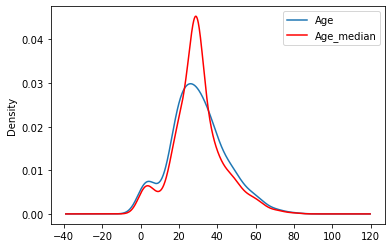

In [11]:
# we can see that the distribution has changed slightly with now more values accumulating towards the median
fig = plt.figure()
ax = fig.add_subplot(111)
X_train["Age"].plot(kind="kde", ax=ax)
X_train.Age_median.plot(kind="kde", ax=ax, color="red")
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc="best")

As mentioned above, the median imputation distorts the original distribution of the variable Age. The transformed variable shows more values around the median value.

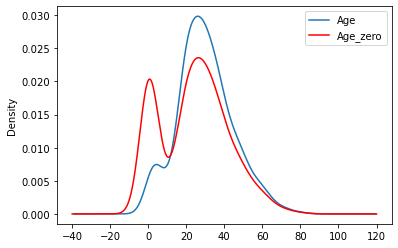

In [12]:
# filling NA with zeroes creates a peak of population around 0, as expected
fig = plt.figure()
ax = fig.add_subplot(111)
X_train["Age"].plot(kind="kde", ax=ax)
X_train.Age_zero.plot(kind="kde", ax=ax, color="red")
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc="best")

Filling NA with 0s also distorts the distribution of the original variable, generating an accumulation of values around 0. We will see in the next lecture a method of NA imputation that preserves variable distribution.

### Machine learning model performance on different imputation methods

#### Logistic Regression

In [13]:
# Let's compare the performance of Logistic Regression using Age filled with zeros or alternatively the median

# model on NA imputed with zeroes
logit = LogisticRegression(
    random_state=44, C=1000
)  # c big to avoid regularization
logit.fit(X_train[["Age_zero", "Fare"]], y_train)
print("Train set zero imputation")
pred = logit.predict_proba(X_train[["Age_zero", "Fare"]])
print(
    "Logistic Regression roc-auc: {}".format(roc_auc_score(y_train, pred[:, 1]))
)
print("Test set zero imputation")
pred = logit.predict_proba(X_test[["Age_zero", "Fare"]])
print(
    "Logistic Regression roc-auc: {}".format(roc_auc_score(y_test, pred[:, 1]))
)
print()

# model on NA imputed with median
logit = LogisticRegression(
    random_state=44, C=1000
)  # c big to avoid regularization
logit.fit(X_train[["Age_median", "Fare"]], y_train)
print("Train set median imputation")
pred = logit.predict_proba(X_train[["Age_median", "Fare"]])
print(
    "Logistic Regression roc-auc: {}".format(roc_auc_score(y_train, pred[:, 1]))
)
print("Test set median imputation")
pred = logit.predict_proba(X_test[["Age_median", "Fare"]])
print(
    "Logistic Regression roc-auc: {}".format(roc_auc_score(y_test, pred[:, 1]))
)

Train set zero imputation
Logistic Regression roc-auc: 0.6863354374091668
Test set zero imputation
Logistic Regression roc-auc: 0.71375

Train set median imputation
Logistic Regression roc-auc: 0.6794863451985858
Test set median imputation
Logistic Regression roc-auc: 0.7244940476190477


In [14]:
print("Average total survival:", X_train.Survived.mean())

Average total survival: 0.3884430176565008


In [15]:
print(
    "Average real survival of children: ",
    X_train[X_train.Age < 15].Survived.mean(),
)
print(
    "Average survival of children when using Age imputed with zeroes: ",
    X_train[X_train.Age_zero < 15].Survived.mean(),
)
print(
    "Average survival of children when using Age imputed with median: ",
    X_train[X_train.Age_median < 15].Survived.mean(),
)

Average real survival of children:  0.5740740740740741
Average survival of children when using Age imputed with zeroes:  0.38857142857142857
Average survival of children when using Age imputed with median:  0.5740740740740741


Children were more likely to survive the catastrophe (0.57 for children vs 0.38 for the entire Titanic). Thus, smaller values of Age are a good indicator of survival.

When we replace NA with zeroes, we are masking the predictive power of Age. After zero imputation it looks like children did not have a greater chance of survival, and therefore the model loses predictive power.

On the other hand, replacing NA with the median, preserves the predictive power of the variable Age, as smaller Age values will favour survival.

### SVM

In [16]:
# Let's compare the performance of SVM using Age filled with zeros or alternatively the median

SVM_model = SVC(
    random_state=44,
    probability=True,
    max_iter=-1,
    kernel="linear",
)
SVM_model.fit(X_train[["Age_zero", "Fare"]], y_train)
print("Train set zero imputation")
pred = SVM_model.predict_proba(X_train[["Age_zero", "Fare"]])
print(
    "Logistic Regression roc-auc: {}".format(roc_auc_score(y_train, pred[:, 1]))
)
print("Test set zero imputation")
pred = SVM_model.predict_proba(X_test[["Age_zero", "Fare"]])
print(
    "Logistic Regression roc-auc: {}".format(roc_auc_score(y_test, pred[:, 1]))
)
print()
SVM_model = SVC(random_state=44, probability=True, max_iter=-1, kernel="linear")
SVM_model.fit(X_train[["Age_median", "Fare"]], y_train)
print("Train set median imputation")
pred = SVM_model.predict_proba(X_train[["Age_median", "Fare"]])
print(
    "Logistic Regression roc-auc: {}".format(roc_auc_score(y_train, pred[:, 1]))
)
print("Test set median imputation")
pred = SVM_model.predict_proba(X_test[["Age_median", "Fare"]])
print(
    "Logistic Regression roc-auc: {}".format(roc_auc_score(y_test, pred[:, 1]))
)
print()

Train set zero imputation
Logistic Regression roc-auc: 0.6879514544153056
Test set zero imputation
Logistic Regression roc-auc: 0.7243452380952381

Train set median imputation
Logistic Regression roc-auc: 0.6931248779852932
Test set median imputation
Logistic Regression roc-auc: 0.7417559523809524



For SVM as well, median imputation leads to better performance of the model, compared to replacing NA with zeroes.

#### Random Forests

In [17]:
# Let's compare the performance of Random Forests using Age filled with zeros or alternatively the median

rf = RandomForestClassifier(n_estimators=100, random_state=39, max_depth=3)
rf.fit(X_train[["Age_zero", "Fare"]], y_train)
print("Train set zero imputation")
pred = rf.predict_proba(X_train[["Age_zero", "Fare"]])
print("Random Forests roc-auc: {}".format(roc_auc_score(y_train, pred[:, 1])))
print("Test set zero imputation")
pred = rf.predict_proba(X_test[["Age_zero", "Fare"]])
print(
    "Random Forests zero imputation roc-auc: {}".format(
        roc_auc_score(y_test, pred[:, 1])
    )
)
print()
rf = RandomForestClassifier(n_estimators=100, random_state=39, max_depth=3)
rf.fit(X_train[["Age_median", "Fare"]], y_train)
print("Train set median imputation")
pred = rf.predict_proba(X_train[["Age_median", "Fare"]])
print("Random Forests roc-auc: {}".format(roc_auc_score(y_train, pred[:, 1])))
print("Test set median imputation")
pred = rf.predict_proba(X_test[["Age_median", "Fare"]])
print("Random Forests roc-auc: {}".format(roc_auc_score(y_test, pred[:, 1])))
print()

Train set zero imputation
Random Forests roc-auc: 0.7555855621353116
Test set zero imputation
Random Forests zero imputation roc-auc: 0.7490476190476191

Train set median imputation
Random Forests roc-auc: 0.7515021366130887
Test set median imputation
Random Forests roc-auc: 0.7697619047619049



Random Forests, as well as SVMs, perform better with median imputation, compared with replacing with zeroes.